# Agent Memory Project

## Load env

In [37]:
import os
import openai

from openai import OpenAI
from dotenv import load_dotenv
from pathlib import Path

# Load path from the environment variable
env_ih1 = os.getenv("ENV_IH1")

dotenv_path = Path(env_ih1)
load_dotenv(dotenv_path=dotenv_path)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY= os.getenv('PINECONE_KEY')
SERPAPI_API_KEY = os.getenv('SERPAPI_API_KEY')
STEAMSHIP_API_KEY = os.getenv('STEAMSHIP_API_KEY')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
HUGGINGFACEHUB_API_TOKEN = os.getenv('HUGGINGFACEHUB_API_TOKEN')
GEMINI_KEY = os.getenv('GEMINI_KEY')

os.environ['PATH'] += os.pathsep + '/usr/bin'

In [38]:
from langsmith import wrappers, traceable

LANGSMITH_API_KEY= LANGSMITH_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"]="memory-project"

## Load Pinecone DB

In [39]:
import time
from pinecone import Pinecone

# configure client
pc = Pinecone(api_key=PINECONE_API_KEY)

# Connect to the existing index
index_name = "memory-project4"  # Replace with your existing index name
# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 170}},
 'total_vector_count': 170}

In [40]:
from langchain.vectorstores import Pinecone as LangchainPinecone
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema import Document

## Create encoder
from semantic_router.encoders import OpenAIEncoder

encoder = OpenAIEncoder(
    name="text-embedding-3-small",
    openai_api_key=OPENAI_API_KEY 
)

## Creating retriever

# Initialize OpenAI Embeddings with text-embedding-3-small
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=OPENAI_API_KEY)

# Initialize LangChain Pinecone retriever
vectorstore = LangchainPinecone(index, embeddings, text_key="text")
retriever = vectorstore.as_retriever()

In [41]:
# Test retrieval
query = "Who is Jean Lambert?"
results = retriever.get_relevant_documents(query)

# Print results
for doc in results:
    print(f"Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}")
    print("-" * 50)

Content: pas exact , en raison de l'importance de son commerce . Je dirais plutôt négociant en tissus , en précisant qu'il l'exerçait en ambulant . Il avait pour cela une voiture à deux chevaux assez spacieuse et confortable . Il était propriétaire de l'ensemble , ce qui paraît assez rare dans cette profession à cette époque . Il faisait des tournées d'environ six mois et son itinéraire comportait beaucoup de petits bourgs qui n'étaient pas desservis par les diligences . C'est à dire qu'il voyageait en zigzag autour de la grande route . Il ne faisait pas les marchés , mais approvisionnait les revendeurs . POUR LA MÉMOIRE FAMILIALE FAMILLE HISTOIRE SOUVENIRS & COMMENTAIRES VOLUME 1 Jean-Georges Lambert Avril 1993 J'ai entrepris ce travail pour mes fils qui tiennent à parts égales, tant de place dans ma vie.  Je veux l'offrir aussi à mes belles-filles pour les remercier, chacune, d'être ce qu'elles sont.
Metadata: {'Author': 'Jean Lambert', 'Chunk_ID': 'Pour la mémoire familiale 1-50_Chu

In [42]:
from langchain.vectorstores import Pinecone

text_field = "text"  # the metadata field that contains our text


## Define tools

In [55]:
import requests
import json
from pprint import pformat
import ast
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState
from langchain_core.prompts import PromptTemplate
from typing import List, Union
from langchain.tools import tool
import re


# Defining Tools
##################################################################################

def format_rag_contexts(matches: list):
    """Formats retrieved document matches into a readable context string."""
    contexts = []
    for x in matches:
        metadata = x.get("metadata", {})  # Safely get metadata
        text = (
            f"Doc name: {metadata.get('Doc name', 'N/A')}\n"
            f"Author: {metadata.get('Author', 'N/A')}\n"
            f"Chunk_ID: {metadata.get('Chunk_ID', 'N/A')}\n"
            f"Content: {metadata.get('text', 'No content available')}"  # Fixed page content reference
        )
        contexts.append(text)

    return "\n---\n".join(contexts)


def translate_to_french(query: str):
    """Translates the given query to French using OpenAI's `o4-mini` model to improve retriebal in French database."""
    
    response = openai.ChatCompletion.create(
        model="gpt-4o",  # "o4-mini" may refer to "gpt-4o"
        messages=[
            {"role": "system", "content": "You are a translation assistant."},
            {"role": "user", "content": f"Translate the following text to French:\n{query}"}
        ],
        temperature=0
    )

    return response

# Tool for RAG search
def rag_search(query: str):
    """Finds relevant information using a natural language query and retrieves ±3 context chunks."""
    
    results = retriever.get_relevant_documents(query, k=10)
    if not results:
        return "⚠ No relevant documents found."

    best_match = results[0].metadata
    doc_name = best_match.get("Doc name", "")
    chunk_id = best_match.get("Chunk_ID", "")
    total_chunks = int(best_match.get("Total_Chunks", 1))

    match = re.match(r"(.+)_Chunk(\d+)", chunk_id)
    if not match:
        return results  

    _, chunk_num = match.groups()
    chunk_num = int(chunk_num)

    # Generate surrounding chunk IDs (-3 to +3, within range)
    expanded_chunk_ids = [f"{doc_name}_Chunk{i}" for i in range(max(1, chunk_num - 3), min(total_chunks, chunk_num + 3) + 1)]

    # Retrieve only matching expanded chunks
    expanded_results = [
        doc for doc in retriever.get_relevant_documents(query, k=6)
        if doc.metadata.get("Chunk_ID") in expanded_chunk_ids
    ]

    # Remove duplicates based on `Chunk_ID`
    unique_chunks = {doc.metadata["Chunk_ID"]: doc.page_content for doc in expanded_results}

    return "\n\n".join(unique_chunks.values()) if unique_chunks else "⚠ No context found."



def final_answer(answer: str, explore_next: str = "Would you like to ask about another topic?", sources: str = None):
    """
    Formats the final answer using a structured approach.

    Args:
        answer (str): The main response.
        explore_next (str, optional): Suggested next question.
        sources (str, optional): Source references.

    Returns:
        str: A well-structured response.
    """

    # 🔹 Construct sources section only if sources are available
    sources_section = f"- **Sources**: {sources}" if sources and sources.lower() != 'none' else ""

    # 🔹 Define the structured prompt within the function
    final_answer_prompt = PromptTemplate.from_template("""
    You are an intelligent assistant helping with historical research.
    Format the final answer for the user by including:

    - **Answer**: {answer}
    {sources_section}
    - **Explore Next**: {explore_next}

    Ensure the response is clear and well-structured.
    """)

    # 🔹 Ensure all fields are properly formatted before passing to the prompt
    structured_input = {
        "answer": answer,
        "explore_next": explore_next if explore_next else "No further suggestions.",
        "sources_section": sources_section
    }

    # 🔹 Use the embedded prompt template to format the response
    formatted_response = final_answer_prompt.format(**structured_input)

    return formatted_response  # ✅ Always returns a well-structured response



# Binding tools to the LLM
##################################################################################

# Create tool bindings with additional attributes
from langchain.tools import Tool

# # Tool for formatting RAG contexts
# format_rag_contexts_tool = Tool.from_function(
#     func=format_rag_contexts,
#     name="format_rag_contexts",
#     description="Formats retrieved document matches into a readable context string.",
#     return_direct=False
# )

# Tool for translating text to French
translate_to_french_tool = Tool.from_function(
    func=translate_to_french,
    name="translate_to_french",
    description="Translates the given query to French using OpenAI's GPT-4o model to improve retrieval in a French database.",
    return_direct=False
)

# Tool for RAG search
rag_search_tool = Tool.from_function(
    func=rag_search,
    name="rag_search",
    description="Finds related information using a natural language query in the family history database.",
    return_direct=False
)

# # Tool for chunk search
# chunk_search_tool = Tool.from_function(
#     func=chunk_search,
#     name="chunk_search",
#     description="Finds related information based on the chunk_id, helping to get more context around a given chunk.",
#     return_direct=False
# )

# Tool for final answer generation
final_answer_tool = Tool.from_function(
    func=final_answer,
    name="final_answer",
    description=(
        "Generates a natural language response to the user's question based on the family memory database. "
        "Links information together from multiple sources but does not invent new information. "
        "If no answer is found, it explicitly states that it doesn't know."
    ),
    return_direct=False
)

# List of all tools
toolbox = [
    translate_to_french_tool,
    rag_search_tool,
    final_answer_tool
]


# OPENAI_API_KEY environment variable must be set
simple_llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = simple_llm.bind_tools(toolbox)


# Defining Agent's node
##################################################################################

# System message
assistant_system_message = SystemMessage(content=("""You are the Family Safe, keeper of the family's collective memory. 
Your role is to decide how to handle user queries using the available tools.

**Tool Usage:**
- Do NOT reuse a tool for the same query.
- Do NOT use any tool more than **5 times**.
- Prioritize **rag_search** for gathering information.
- Do not mix sources from different contexts unless necessary.
- Alsways check at leats 2 ***Doc name*** to ensure the information is correct.

**Response Protocol:**
- If tools provides no answer, state that you don't know or can't any information about this topic"
- NEVER invent information or use data beyond the family memory.
- Always provide sources via the **final_answer** tool.
- Chunk_search must be in the scracthpad to point to final_answer.
- Discard any page content that looks like a table of content: you won't find any useful information there apart from page numbers.

By following these rules, you ensure accurate and responsible responses."""))

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([assistant_system_message] + state["messages"])]}


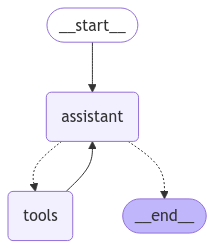

In [44]:
from langgraph.checkpoint.memory import MemorySaver

# Defining Graph
##################################################################################

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(toolbox))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
react_graph_with_memory = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph_with_memory.get_graph(xray=True).draw_mermaid_png()))

# Define oracle function
################################################################################################

# Specify a thread
def oracle(user_request: str, thread_id = "1", verbose = False):
    config = {"configurable": {"thread_id": thread_id}}
    messages = react_graph_with_memory.invoke({"messages": [HumanMessage(content=user_request)]}, config)
    if verbose:
        for message in messages['messages']:
            message.pretty_print()
    else:
        messages['messages'][-1].pretty_print()

In [45]:
oracle(
    user_request="Does he have siblings?", 
    thread_id="300"
)

================================== Ai Message ==================================

- **Answer**: Oui, il a des frères et sœurs. Louis et Rachel, ses parents, ont eu six enfants: Charlotte, Jacques, Alexandre, Lehmann (ou Clément), Marx, et Julie. Notre ancêtre direct est Lehmann, né en 1800.

- **Explore Next**: Would you like to ask about another topic?


In [46]:
oracle(
    user_request="When did Jean start to write this book?", 
    thread_id="5"
)

================================== Ai Message ==================================

**Answer**: I couldn't find specific information regarding when Jean started to write his book. The details may not be available in the family history database.

**Explore Next**: Would you like to ask about another topic?


In [47]:
oracle(
    user_request="When did Jean's mother died?", 
    thread_id="5"
)

================================== Ai Message ==================================

**Answer**: Jean's mother died on March 29, 1963.

**Explore Next**: Would you like to ask about another topic?


In [59]:
oracle(
    user_request="Who is Elon Musk?", 
    thread_id="70"
)

================================== Ai Message ==================================

**Answer**: I don’t know any specific information about Elon Musk.

**Explore Next**: Would you like to ask about another topic?


In [49]:
oracle(
    user_request="Combien d'enfant a Jean?", 
    thread_id="9"
)

================================== Ai Message ==================================

**Answer**: Jean a eu 6 enfants : Charlotte, Jacques, Alexandre, Lehmann (ou Clément), Marx et Julie. Ces enfants sont nés à Froeningen entre 1795 et 1802.

**Explore Next**: Would you like to ask about another topic?


In [50]:
oracle(
    user_request="Can you check for sons in chunk 7 & 8?", 
    thread_id="7"
)

================================== Ai Message ==================================

### Answer:
In the documents related to 'sons' from chunks 7 and 8, there is no specific mention or detailed information about any sons. The content primarily revolves around the author's reflections on their upbringing, family history, and their mother's death. Unfortunately, this content does not contain pertinent information about sons within these specific chunks.

### Explore Next:
Would you like to ask about another topic?


In [51]:
oracle(
    user_request="What does Jean has to say about it?", 
    thread_id="8"
)

================================== Ai Message ==================================

- **Answer**: Jean's sentiments appear to involve a nuanced view of Jewish communities, acknowledging challenges and advocating for their rights and recognition. He highlights the moral responsibility of society to improve their situation, suggesting that Judaism should not be seen in a negative light and emphasizes the importance of respect and recognition of individuals in the community.

- **Explore Next**: Would you like to ask about another topic?


In [52]:
oracle(
    user_request="Expand on his personal anecdotes", 
    thread_id="5052"
)

================================== Ai Message ==================================

**Answer**: The personal anecdotes reflect a rich tapestry of family history, emphasizing the dramatic changes in cultural values and traditions over generations. The narrator shares insights from their father's notes, revealing a serene perspective on Jewish identity and societal norms from the past, contrasting sharply with contemporary views. They discuss the significance of life events, such as birth and death, and how societal attitudes have evolved, particularly regarding mourning practices and the impact of war. These reflections serve as a bridge between generations, illustrating the profound influence of historical context on personal experiences and family legacies.

**Explore Next**: Would you like to ask about another topic?


## DEMO

In [57]:
import gradio as gr
from langchain.schema import HumanMessage

# Initialize conversation history
chat_history = []

def query_oracle(user_request: str):
    """Invokes the LangGraph Oracle and returns a structured response."""
    global chat_history

    try:
        # Invoke Oracle using LangGraph with memory
        config = {"configurable": {"thread_id": "29"}}
        response = react_graph_with_memory.invoke({"messages": [HumanMessage(content=user_request)]}, config)

        # Extract latest message (handle None case)
        response_text = response["messages"][-1].content if response and "messages" in response else "⚠ No valid response."

    except Exception as e:
        response_text = f"🚨 Error: {str(e)}"

    # Store user input and Oracle response as tuple
    chat_history.append((user_request, response_text))
    return chat_history  # Return updated chat history for Gradio Chatbot

# Function to clear chat history
def clear_chat():
    global chat_history
    chat_history = []  # Reset chat history
    return chat_history  # Reset chatbot UI

# Set up Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("# 🔮 LangGraph Oracle Assistant")
    gr.Markdown("Ask any question about your family history, and the Oracle will respond.")

    chatbot = gr.Chatbot(label="Chat History")  # Chat interface

    with gr.Row():
        user_input = gr.Textbox(label="Your Question", placeholder="Type your question here...", lines=1)
        submit_button = gr.Button("Submit")

    # Clear Chat Button
    clear_button = gr.Button("Clear Chat")

    # Connect Buttons to Functions
    submit_button.click(query_oracle, inputs=[user_input], outputs=[chatbot])
    clear_button.click(clear_chat, inputs=None, outputs=[chatbot])  # Clears the chat

# Launch Gradio App
demo.launch()


C:\Users\aurel\AppData\Roaming\Python\Python312\site-packages\gradio\components\chatbot.py:282: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


In [54]:
def query_oracle(text: str):
    """Invokes the LangGraph agent and extracts a cleaned response."""
    print(f"🔍 [DEBUG] Query received: {text}")

    response = oracle(user_request=text, thread_id="500")

    print(f"📡 [DEBUG] Raw Oracle response: {response}")
    print(f"🔍 [DEBUG] Type of response: {type(response)}")

    if response is None:
        print("⚠ [DEBUG] Oracle returned None. Possible failure in agent processing.")
        return "⚠ No response received from Oracle. Please try again."

    return response

query_oracle("Hello! How can you help me?")


🔍 [DEBUG] Query received: Hello! How can you help me?
================================== Ai Message ==================================

Hello! I can assist you with queries related to family history, collective memories, and other related topics. If you have any specific questions or topics you'd like to know more about, feel free to ask!
📡 [DEBUG] Raw Oracle response: None
🔍 [DEBUG] Type of response: <class 'NoneType'>
⚠ [DEBUG] Oracle returned None. Possible failure in agent processing.


'⚠ No response received from Oracle. Please try again.'